# <span style="color:#1111AA">Fabry-Perot cavity: Impedance matched</span>

# Introduction

The properties of a Fabry-Perot cavity depends on the parameters of the cavity. In this notebook we will look at how the cavity properties depend on the transmittance and reflectance of the two cavity mirrors, or more exact, on how the relative transmittance between the two mirrors affects the reflected, circulating, and transmitted fields. 

**We recommend that you have done the following notebooks before starting this one:**

* Learning laser interferometry
    * 02_Plane_waves
        * 01_Fabry_Perot_cavity
            * [01_Resonance.ipynb](01_Resonance.ipynb)

or have corresponding basic experience of Ipython notebooks, PyKat, Finesse, and resonance condition of a cavity. The link above only works if you started ipython notebook in the top directory of this course.

**Reading material and references:**

[1] [A. Freise, K. Strain, D. Brown, and C. Bond, "Interferometer Techniques for Gravitational-Wave Detection", *Living Reviews in Relativity* **13**, 1 (2010)](http://arxiv.org/pdf/0909.3661v3). - Living review article (more like a book) on laser interferometry in the frequency domain for detecting gravitational waves, and FINESSE.

[2] [A. Freise, D. Brown, and C. Bond, "Finesse, Frequency domain INterferomEter Simulation SoftwarE"](http://kvasir.sr.bham.ac.uk/redmine/attachments/download/131/Finesse_2.0_manual.pdf). - FINESSE-manual

[3] [FINESSE syntax reference](http://www.gwoptics.org/finesse/reference/) - Useful online syntax reference for FINESSE. Also available in the Finesse manual [2], but this online version is updated more often.

** After this session you will be able to...**

* construct a over coupled, under coupled, and impedance matched Fabry-Perot cavity
* conclude from phase and power measurements if a cavity is over coupled, under coupled, or impedance matched.

# Over coupled, under coupled, and impedance matched cavities

## Importing packages

We start by loading the needed packages:

In [219]:
import numpy as np                         # Importing numpy
import matplotlib                          # Importing matplotlib, so we can plot figures
import matplotlib.pyplot as plt                   
from pykat import finesse                  # Importing the pykat.finesse package
from pykat.commands import *               # Importing all packages in pykat.commands.
from IPython.display import display, HTML  # Allows us to display HTML.

# Telling the notebook to make plots inline.
%matplotlib inline      
# Initialises the PyKat plotting tool.
pykat.init_pykat_plotting(dpi=90)          

## The Optical Layout

The setup we want to model looks like this, where we will play with the reflectance and transmittance of the two mirrors.

<img src="fabry-perot.svg" style="width: 500px;"/>

## The FINESSE model

Lets build an optical model in FINESSE matching the setup in the figure above.

In [220]:
basekat=finesse.kat() # initialising Finesse
basekat.verbose = False

# Finesse-code
basecode = """
l laser 1 0 n0   # Laser (Power = 1 W, wavelength offset = 0)
s s1 1 n0 nc1    # Space (Length = 1 m)

## The cavity ##
m m1 0.7 0.3 0 nc1 nc2  # Mirror  (R = 0.8, T = 0.2, phi = 0)
s sL 4000 nc2 nc3       # Space (Length = 4 km)
m m2 0.8 0.2 0 nc3 nc4  # Mirror  (R = 0.9, T = 0.1, phi = 0)
"""

# Parsing the FINESSE-code
basekat.parseKatCode(basecode) 

We call this kat-object *basekat* since it describes the core optics of the system we will investigate in this notebook.

## Simulation example: Power response on resonance

In this example we investigate what happens with the reflected, circulating, and transmitted power for a cavity on resonance as we sweep the transmittance $T_1$ of the input mirror `m1` while keeping the total transmittance to $T_1 + T_2 = 0.6$. Here, $T_2$ is the transmittance of the end mirror `m2`. We also keep the mirrors lossless, that is, $R_1 = 1-T_1$ and $R_2 = 1-T_2$. To achieve this we use the `func` and `put` commands in FINESSE.

In [221]:
# Copying basekat
kat1 = deepcopy(basekat)

# Adding detectors and simulation instructions
code = """
## Detectors ##
pd refl nc1        # Photo diode measuring reflected DC power 
pd circ nc2        # Photo diode measuring circulating DC power
pd tran nc4        # Photo diode measuring transmitted DC power

## Simulation instructions ##
xaxis m1 T lin 0 0.6 200   # Varying transmittance of input mirror m1.
yaxis abs                  # Plotting the amplitude of the detector measurements. 

## Functions computing reflectance and transmittance ##
func R1 = 1-$x1             # Reflectance of m1 (lossless)
func T2 = 0.6 - $x1         # Transmittance of m2 (T1 + T2 = 0.6)
func R2 = 1-$T2             # Reflectance of m2

## Setting values ## 
put m1 R $R1                # Setting reflectance of m1 to R1
put m2 T $T2                # Setting transmittance of m2 to T2
put m2 R $R2                # Setting reflectance of m2 to R2
"""

kat1.parseKatCode(code) # Parsing the FINESSE-code
out1 = kat1.run()       # Running the FINESSE-simulation, storing output in out1.

Plotting the power detected by the photo diodes:

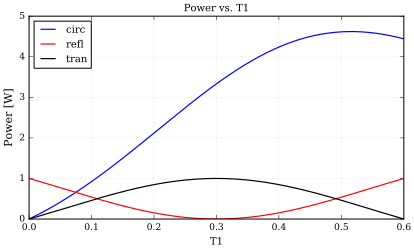

In [222]:
fig1a = out1.plot(detectors=['refl','circ','tran'], 
                  xlabel='T1', 
                  ylabel='Power [W]', 
                  title = 'Power vs. T1')

In the figure we see that for 

* **under-coupled** cavity, $T_1 < T_2$ : Starting from $T_1 = 0$ where all of the incoming field is directly reflected by the input miror, more and more of the field is transmitted through as $T_1$ approaches $T_2$. 
* **impedance matched** cavity, $T_1 = T_2$ : all of the incoming power is transmitted through the cavity, none is reflected. This is because of the field leaking back out from the cavity through the input mirror perfectly cancels out the directly reflected field (see the task below to understand why).  
* **over-coupled** cavity, $T_1 > T_2$ : The field leaking back out from the cavity through the input mirror now dominates over the directly reflected field, hence, the resulting reflected field grows with increasing $T_1$. As the energy need to be conserved, the transmitted power goes down.

We also see that the intra-cavity field is biggest for an over-coupled cavity, which is utilised in LIGO for example. See section 5.1 in the living review article [1] if you want to read more about under-coupled, over-coupled, and impedance matched cavities.

In the figure below, we plot $R_1$, $R_2$, and $T_2$ as functions of $T_1$ so we can see that the instructions we gave FINESSE were correct:

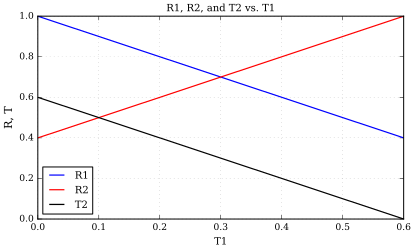

In [218]:
# Reflectances and transmittances
fig1b = out1.plot(detectors=['R1','R2','T2'], 
                  xlabel='T1', 
                  ylabel='R, T', title='R1, R2, and T2 vs. T1')

The figure shows that all the mirror parameters behaves as we intended them to.

# Tasks

## Power and phase response

Modify the example above to measure amplitude and phase of the reflected, circulating, and transmitted field, as a function of the tuning of the end mirror `m2`. Do this for three cases: 

* Over-coupled cavity ($T_1 > T_2$)
* Under-coupled cavity ($T_1 < T_2$)
* Impedance matched cavity ($T_1 = T_2$)

Especially, compare the phase response in the three cases, and try to explain it.

**Answer:**

# Tasks with answers

## Power and phase response

Modify the example above to measure amplitude and phase of the reflected, circulating, and transmitted field, as a function of the tuning of the end mirror `m2`. Do this for three cases: 

* Over-coupled cavity ($T_1 > T_2$)
* Under-coupled cavity ($T_1 < T_2$)
* Impedance matched cavity ($T_1 = T_2$)

Especially, compare the phase response in the three cases, and try to explain it.

**Answer:**

From the code above we need to:

* Switch to amplitude detectors
* Change the `xaxis` to sweep tuning of `m2`
* Change the `yaxis` to `abs:deg`
* We can remove the `func`s and `put`s from the FINESSE code, and set the mirror parameters using PyKat as wee do not sweep these in the simulation.

In [207]:
kat2 = deepcopy(basekat)
code = """
## Detectors ##

# Photo diodes measureing DC-power
ad refl 0 nc1   
ad circ 0 nc2
ad tran 0 nc4

## Simulation instructions ##
xaxis m2 phi lin -90 270 2000   # Varying transmittance of input mirror m1.
yaxis abs:deg                 # Plotting the amplitude of the detector measurements. 
"""
kat2.parseKatCode(code) # Parsing the FINESSE-code

Setting mirror parameters, and running the three cases:

In [204]:
T_tot = 0.3

# Over-coupled
T1 = 0.25
T2 = T_tot-T1
R1 = 1-T1
R2 = 1-T2
kat2.m1.T = T1
kat2.m1.R = R1
kat2.m2.T = T2
kat2.m2.R = R2
out2a = kat2.run()

# Under-coupled
T1 = 0.05
T2 = T_tot-T1
R1 = 1-T1
R2 = 1-T2
kat2.m1.T = T1
kat2.m1.R = R1
kat2.m2.T = T2
kat2.m2.R = R2
out2b = kat2.run()

# Impedance matched
T1 = 0.15
T2 = T_tot-T1
R1 = 1-T1
R2 = 1-T2
kat2.m1.T = T1
kat2.m1.R = R1
kat2.m2.T = T2
kat2.m2.R = R2
out2c = kat2.run() 

**Plotting the results:**

For the **over-coupled cavity**, i.e., with $T_1 > T_2$:

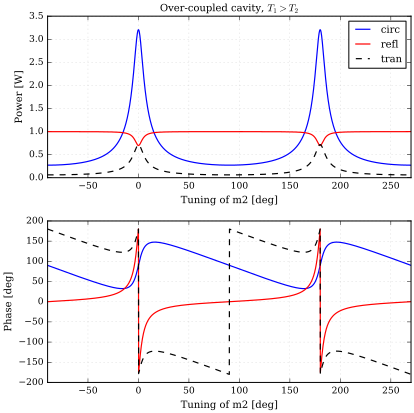

In [208]:
fig2a = out2a.plot(ylabel = 'Power [W]', 
                   xlabel = 'Tuning of m2 [deg]',
                   x2label = 'Tuning of m2 [deg]',
                   title = 'Over-coupled cavity, $T_1>T_2$',
                   styles={'circ':'b-','refl':'r-','tran':'k--'})

Recall that a field is phase shifted 90 degrees ($\pi/2$) on transmission and 0 degrees on reflection in the phase convention used in FINESSE (see sections 2.1-2.4 in the living review article [1]). In short, for an over coupled cavity the field leaking back out through the input mirror dominates over the field that is directly reflected by the input mirror, thus the resulting reflected field is phase shifted 180 degrees compared to the incoming field. 

**Over coupled cavity ---> reflected field dominated by field leaking out from the cavity**. 

A longer explanation of the phases of the fields follows:

* **Circulating:** We need to distinguish betwen two fields: the one just entering the cavity, and the field that just completed a roundtrip in the cavity. The field just intering the cavity has been transmitted through one surface, thus, it is phase shifted 90 degrees compared to the incoming field. The phase of the field just completed a roundtrip depends on the microscopic cavity length that we call tuning and express in degrees. 
    * **Off resonance**, the roundtrip phase shift is 180 degrees, thus it cancels out a part of the field that just entered the cavity. However, as the field entering the cavity is always bigger than the field returning back after a roundtrip, the field just entering "wins" and the overall field has the phase of 90 degrees compared to the incoming field. 
    * **On resonance**, the roundtrip phase is 0. Thus field returning back after a roundtrip and the field just entering the cavity has the same phase of 90 degrees compared to the incoming field.
    * **In between** off resonance and resonance, the roundtrip phase is between 180 to 0 degrees. The phase of the overall field is determined by the superpositon of the two fields.


* **Reflected:** The reflected field has two components that we need to distinguish: one directly reflected off the input mirror, and one leaking back out from the cavity. The directly reflected field has a phase of 0 degrees, and its magnitude is given by the incoming amplitude multiplied by the square root of the input mirror reflectance. The field leaknig back out depends on the cavity properties.
    * **Off resonance** the field leaking back out has a phase of 180 degrees: 90 degrees when inside the cavity, as seen above, plus 90 degrees when transmitted back out through the input mirror. However, this field is small as the intra cavity field is small. The two fields cancel each other out as much as possible, but the bigger directly reflected component "wins" and the resulting reflected field has 0 phase shift compared to the incoming field.
    * **On resonance**, the phase situation is the same for the two fields as it was off resonance, but now the the field leaking out from the cavity "wins" as it is bigger than the field directly reflected by the input mirror. Thus, the resulting reflected field is phase shifted by 180 degrees compared to the incoming field.
    * **In between** off resonance and resonance, the phase of the intra cavity field changes, thus the field leaking back out, as well as the resulting reflected field changes accordingly.

* **Transmitted:** The phase of the transmitted field is just the same as the circulating field, plus the extra 90 degrees phase shift due to the transmission through the end mirror.

For the **under-coupled cavity**, i.e., with $T_1 < T_2$:

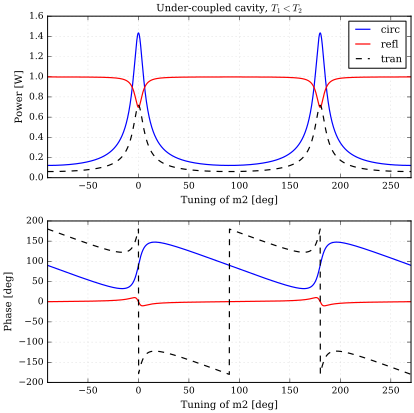

In [209]:
fig2b = out2b.plot(ylabel = 'Power [W]', 
                   xlabel = 'Tuning of m2 [deg]',
                   x2label = 'Tuning of m2 [deg]',
                   title = 'Under-coupled cavity, $T_1 < T_2$',
                   styles={'circ':'b-','refl':'r-','tran':'k--'})

The phase situation for the circulating and transmitted fields are the same as for the over-coupled cavity, as we can see by comparing the two figures. The difference is that the reflected field now has 0 phase shift when the cavity is on resonance, compared to 180 degrees phase shift for the over-coupled cavity. The reason is that the smaller circulating field and the smaller transmittance of the input mirror allows less leakage back out through the input mirror, thus, the resulting reflected field is now dominated by the field directly reflected by the input mirror.

For the **Impedance matched cavity**, i.e. with $T_1 = T_2$:

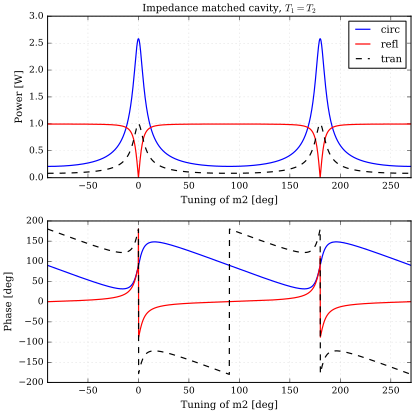

In [210]:
fig2c = out2c.plot(ylabel = 'Power [W]', 
                   xlabel = 'Tuning of m2 [deg]',
                   x2label = 'Tuning of m2 [deg]',
                   title = 'Impedance matched cavity, $T_1 = T_2$', 
                   styles={'circ':'b-','refl':'r-','tran':'k--'})

As we see in the figure above, for an impedance matched cavity on resonance, the field leaking back out from the cavity, and the directly reflected field, exactly cancel out each other (as long as the mirrors are lossless).

# Summary

In this notebook we have investigated how the power and phase response of a Fabry-Perot cavity depends on if the cavity is 
* Over-coupled ($T_1 > T_2$)
* Under-coupled ($T_1 < T_2$)
* Impedance matched ($T_1 = T_2$)

Most importantly, we have seen that:

* An over-coupled cavity has the largest circulating power (keeping $T_1+T_2$ constant).
* For an over-coupled cavity on resonance the reflected field is phase shifted by 180 degrees relative to the incoming field
* For an impedance matched cavity on resonance, the reflected field vanishes, all power is transmitted through the cavity. 